<div class="alert alert-info">
    <h1>Do We Need to Adjust for Single-Scattering and Shadowing?</h1>
Robert S. French, rfrench@seti.org - Last updated April 25, 2023

<h2>The Problem</h2>

<ul>
<li>French (2012) plotted low-phase angle (&lt; 60 degrees) Normal EWs and found that observations taken with
    the emission angle or incidence angle within 6 degrees of the ring plane were systematically less
    bright than other observation (see their Figure 6a).</li>
    
<li>French (2012) used this as justification for needing to adjust all measurements for single-scattering
    and shadowing using formulas from Chandrasekhar (see their Appendix).</li>
    
<li>By minimizing the scatter of these low-phase angle points, they derived an "equivalent tau" optical depth
    of 0.033. All measurements were adjusted using the Chandrasekhar formula based on this tau.</li>
    
<li>The end result was that the ring appeared brighter, because accounting for single-scattering and shadowing
    made each point brighter.</li>
    
<li>Do we still need to do this?</li>
</ul>
    
<h2>Methodology</h2>

<ul>
<li>Reproduce Fig 6a using original 2012 data to verify reproduceability.</li>
    
<li>Reproduce Fig 6a using original 2012 data adjusted for known differences in calibration to see if the new calibration is primarily responsible for the observed effect. Also optimize for tau.</li>

<li>Reproduce Fig 6a using new data (limited to 2012 observations) to see what changes the other processing changes caused. Also optimize for tau.</li>

<li>Create a new equivalent figure using ALL new low-phase observations. Also optimize for tau.</li>

<li>Create a new equivalent figure using ALL new low-phase observations with 1-degree slices. Also optimize for tau.</li>
    
<li>Fit a phase curve for ALL new observations optimizing for tau.</li>
    
<li>Decide if the adjustment is still required.</li>
</ul>
</div>

# Read Data and Initialize Data Structures

In [1]:
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util.f_ring import (add_cisscal_ratios,
                                add_hover,
                                compute_corrected_ew_col,
                                find_common_data_2012,
                                fit_hg_phase_function,
                                hg_func,
                                print_hg_params,
                                read_cassini_ew_stats)

%matplotlib notebook

In [2]:
### PLOTTING AND OPTIMIZATION

def compare_tau_no_tau_60(obsdata, col='Normal EW Mean', small_plot=False):
    low_phase = obsdata['Mean Phase'] <= 60
    low_phase_obsdata = obsdata[low_phase]
    low_e = np.abs(low_phase_obsdata['Mean Emission'].to_numpy()-90) < 6
    low_i = np.abs(low_phase_obsdata['Incidence'].to_numpy()-90) < 6
    low_ei = low_e | low_i

    best_tau = None
    best_ratio = 1e38
    for tau in np.arange(0, 0.02, 0.001):
        corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=('Normal EW Mean', tau))
        mean_low_tau = np.mean(corrected_ew[low_ei])
        mean_notlow_tau = np.mean(corrected_ew[~low_ei])
        ratio = mean_low_tau / mean_notlow_tau
        if ratio < 1:
            ratio = 1/ratio
        if ratio < best_ratio:
            best_ratio = ratio
            best_tau = tau
#         print(f'{tau:.3f}: {ratio:.5f}')
#     print()

    mean_low = np.mean(low_phase_obsdata[col][low_ei])
    mean_notlow = np.mean(low_phase_obsdata[col][~low_ei])
    print(f'Mean Normal EW low E/I: {mean_low:.3f}')
    print(f'Mean Normal EW Other:   {mean_notlow:.3f}')
    print(f'Ratio:                       {mean_notlow/mean_low:.3f}')
    print()
    print(f'BEST TAU: {best_tau:.3f}: {best_ratio:.5f}')

    corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=(col, best_tau))
    
    if best_tau != 0:
        mean_low_tau = np.mean(corrected_ew[low_ei])
        mean_notlow_tau = np.mean(corrected_ew[~low_ei])
        print(f'Mean Normal EW low E/I: {mean_low_tau:.3f}')
        print(f'Mean Normal EW Other:   {mean_notlow_tau:.3f}')
        print(f'Ratio:                       {mean_notlow_tau/mean_low_tau:.3f}')
        print()
        overall_ratio = np.mean(corrected_ew) / np.mean(low_phase_obsdata[col])
        print(f'Overall Tau/no-Tau ratio: {overall_ratio:.3f}')

    if small_plot:
        fig, ax = plt.subplots(2, 1, figsize=(9,8))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(9,4))
    if small_plot:
        p1 = ax[0].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           low_phase_obsdata[col][low_ei], s=3, alpha=0.3, c='red', label='Low e or i')
        p2 = ax[0].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           low_phase_obsdata[col][~low_ei], s=3, alpha=0.3, c='blue', label='Other')
    else:
        p1 = ax[0].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           low_phase_obsdata[col][low_ei], c='red', label='Low e or i')
        p2 = ax[0].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           low_phase_obsdata[col][~low_ei], c='blue', label='Other')
    add_hover(low_phase_obsdata[low_ei], p1, low_phase_obsdata[~low_ei], p2)
    ax[0].set_xlim(10,60)
    if not small_plot:
        ax[0].set_ylim(0.4,0.85)
    ax[0].legend(loc='upper left')
    ax[0].set_xlabel('Phase Angle (°)')
    ax[0].set_ylabel(col)
    ax[0].set_title('(no tau)')

    if small_plot:
        p1 = ax[1].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           corrected_ew[low_ei], s=3, alpha=0.3, c='red', label='Low e or i')
        p2 = ax[1].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           corrected_ew[~low_ei], s=3, alpha=0.3, c='blue', label='Other')
    else:
        p1 = ax[1].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           corrected_ew[low_ei], c='red', label='Low e or i')
        p2 = ax[1].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           corrected_ew[~low_ei], c='blue', label='Other')
    add_hover(low_phase_obsdata[low_ei], p1, low_phase_obsdata[~low_ei], p2)
    ax[1].set_xlim(10, 60)
    if not small_plot:
        ax[1].set_ylim(0.4, 0.85)
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel('Phase Angle (°)')
    ax[1].set_ylabel(col)
    ax[1].set_title(f'(tau={best_tau:.3f})')
    plt.tight_layout()
    
def optimize_phase_tau(obsdata, col='Normal EW Mean', small_plot=False):
    base_params, _, base_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Normal EW Mean', None))
    best_tau = None
    best_params = None
    best_std = 1e38
    for tau in np.arange(0, 0.01, 0.001):
        params, _, std = fit_hg_phase_function(2, None, obsdata, col_tau=('Normal EW Mean', tau))
        if std < best_std:
            best_std = std
            best_params = params
            best_tau = tau
        print(f'{tau:.3f}: {std:.7f}')
    print()

    print('NO TAU:')
    print_hg_params(base_params)
    print()
    print(f'BEST TAU: {best_tau:.3f}: {best_std:.5f}')
    print_hg_params(best_params)
    print(f'Base std: {base_std:.7f}')
    print(f'Best std: {best_std:.7f}')
    
    corrected_ew = compute_corrected_ew_col(obsdata, col_tau=(col, best_tau))
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)

    if small_plot:
        fig, ax = plt.subplots(2, 1, figsize=(9,8))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(9,4))
    if small_plot:
        p1 = ax[0].scatter(obsdata['Mean Phase'], obsdata[col], s=3, alpha=0.3, c='black')
    else:
        p1 = ax[0].scatter(obsdata['Mean Phase'], obsdata[col], c='black')
    add_hover(obsdata, p1)
    full_phase_model = hg_func(base_params, xrange)
    ax[0].plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax[0].set_xlim(0, 180)
    ax[0].set_xlabel('Phase Angle (°)')
    ax[0].set_ylabel(col)
    ax[0].set_yscale('log')
    ax[0].set_title('(no tau)')

    if small_plot:
        p1 = ax[1].scatter(obsdata['Mean Phase'], corrected_ew, s=3, alpha=0.3, c='black')
    else:
        p1 = ax[1].scatter(obsdata['Mean Phase'], corrected_ew, c='black')
    add_hover(obsdata, p1)
    full_phase_model = hg_func(best_params, xrange)
    ax[1].plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax[1].set_xlim(0, 180)
    ax[1].set_xlabel('Phase Angle (°)')
    ax[1].set_ylabel(col)
    ax[1].set_yscale('log')
    ax[1].set_title(f'(tau={best_tau:.3f})')
    plt.tight_layout()

In [3]:
obsdata = read_cassini_ew_stats('../data_files/cass_ew_60_0.csv')
print()
obsdata01 = read_cassini_ew_stats('../data_files/cass_ew_0_1.csv')
print()

# Find the intersection of the old and new data
commondata = find_common_data_2012(obsdata)

# Add CISSCAL ratios
commondata = add_cisscal_ratios(commondata)

commondata33 = commondata.loc[:'ISS_041RF_FMOVIE002_VIMS']
commondata36 = commondata.loc['ISS_044RF_FMOVIE001_VIMS':]
print('CISSCAL 3.6 starts at', commondata.loc['ISS_044RF_FMOVIE001_VIMS']['Date'])
print('Number of CISSCAL 3.3 observations:', len(commondata33))
print('Number of CISSCAL 3.6 observations:', len(commondata36))
cratio = (commondata['EW Mean Ratio']/commondata['CISSCAL Ratio']).mean()
cratio33 = (commondata33['EW Mean Ratio']/commondata33['CISSCAL Ratio']).mean()
cratio36 = (commondata36['EW Mean Ratio']/commondata36['CISSCAL Ratio']).mean()

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 155
Total slices: 155
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/cass_ew_0_1.csv **
Unique observation names: 210
Total slices: 38467
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27

Total number of new observation names: 155
Total number of observation names from 2012: 25
Number of observation names in common: 23
Missing observation names: {'ISS_007RI_LPHRLFMOV001_PRIME', 'ISS_036RF_FMOVIE002_VIMS'}
CISSCAL 3.6 starts at 2007-05-05 04:51:11
Number of CISSCAL 3.3 observations: 12
Number of CISSCAL 3.6 observations: 11


# Reproduce Figure 6a and Compute Tau Limited to 2012 Observations

USING 2012 ORIGINAL DATA
Mean Normal EW low E/I: 0.548
Mean Normal EW Other:   0.577
Ratio:                       1.054

BEST TAU: 0.000: 1.00129


<IPython.core.display.Javascript object>


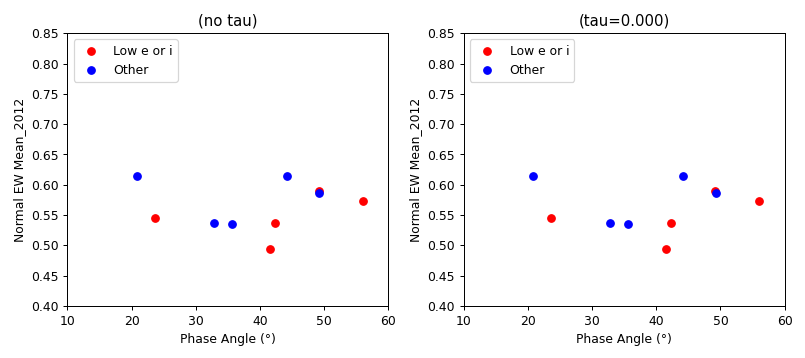

In [4]:
print('USING 2012 ORIGINAL DATA')
compare_tau_no_tau_60(commondata, col='Normal EW Mean_2012')

USING 2012 ORIGINAL DATA ADJUSTED FOR KNOWN CALIBRATION CHANGES
Mean Normal EW low E/I: 0.532
Mean Normal EW Other:   0.549
Ratio:                       1.033

BEST TAU: 0.000: 1.00129


<IPython.core.display.Javascript object>


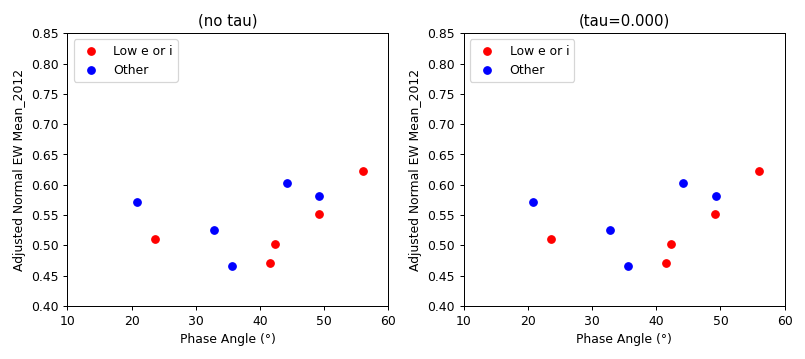

In [5]:
print('USING 2012 ORIGINAL DATA ADJUSTED FOR KNOWN CALIBRATION CHANGES')
compare_tau_no_tau_60(commondata, col='Adjusted Normal EW Mean_2012')

USING NEW DATA LIMITED TO 2012 OBSERVATIONS
Mean Normal EW low E/I: 0.525
Mean Normal EW Other:   0.526
Ratio:                       1.001

BEST TAU: 0.000: 1.00129


<IPython.core.display.Javascript object>


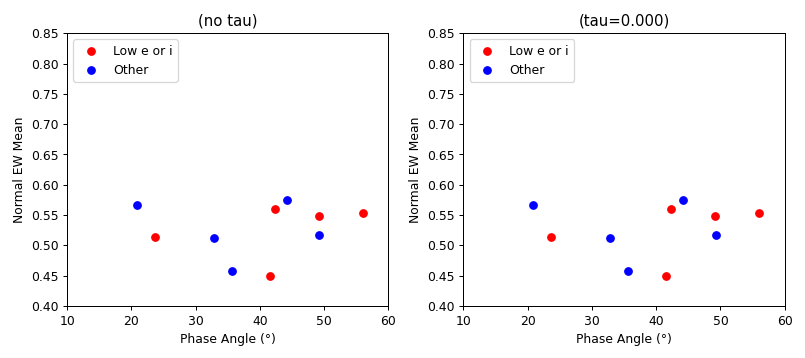

In [6]:
print('USING NEW DATA LIMITED TO 2012 OBSERVATIONS')
compare_tau_no_tau_60(commondata)

# Reproduce Figure 6a and Compute Tau Using All New Data

USING ALL NEW LOW-PHASE DATA
Mean Normal EW low E/I: 0.524
Mean Normal EW Other:   0.585
Ratio:                       1.117

BEST TAU: 0.013: 1.00011
Mean Normal EW low E/I: 0.612
Mean Normal EW Other:   0.612
Ratio:                       1.000

Overall Tau/no-Tau ratio: 1.105


<IPython.core.display.Javascript object>


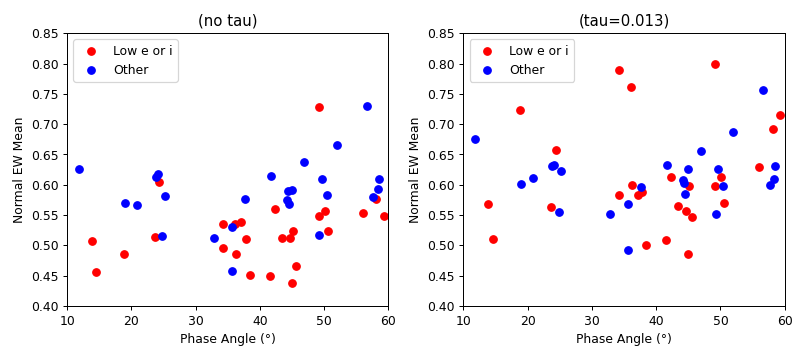

In [7]:
print('USING ALL NEW LOW-PHASE DATA')
compare_tau_no_tau_60(obsdata)

USING ALL NEW LOW-DATA DATA WITH 1-DEGREE SLICES
Mean Normal EW low E/I: 0.531
Mean Normal EW Other:   0.584
Ratio:                       1.099

BEST TAU: 0.013: 1.00367
Mean Normal EW low E/I: 0.614
Mean Normal EW Other:   0.612
Ratio:                       0.996

Overall Tau/no-Tau ratio: 1.094


<IPython.core.display.Javascript object>


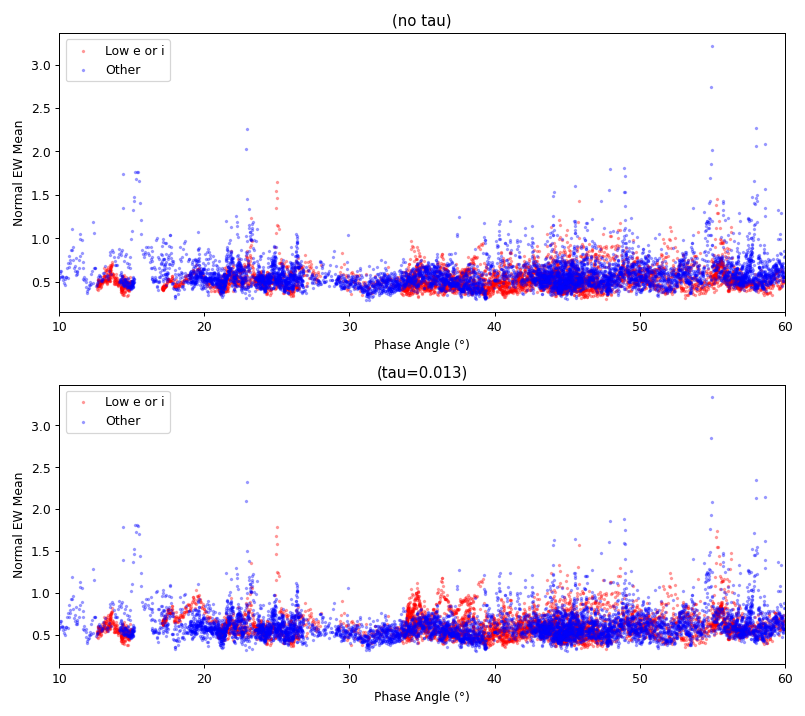

In [8]:
print('USING ALL NEW LOW-DATA DATA WITH 1-DEGREE SLICES')
compare_tau_no_tau_60(obsdata01, small_plot=True)

# Optimize Tau for Entire Phase Curve

0.000: 0.0543187
0.001: 0.0536121
0.002: 0.0535614
0.003: 0.0540765
0.004: 0.0550615
0.005: 0.0564189
0.006: 0.0580625
0.007: 0.0599166
0.008: 0.0619205
0.009: 0.0640248

NO TAU:
g1 = -0.653 / scale1 =  1.669 / weight1 = 0.643
g2 = -0.026 / scale2 =  0.927 / weight2 = 0.357

BEST TAU: 0.002: 0.05356
g1 = -0.653 / scale1 =  1.680 / weight1 = 0.641
g2 = -0.025 / scale2 =  0.941 / weight2 = 0.359
Base std: 0.0543187
Best std: 0.0535614


<IPython.core.display.Javascript object>


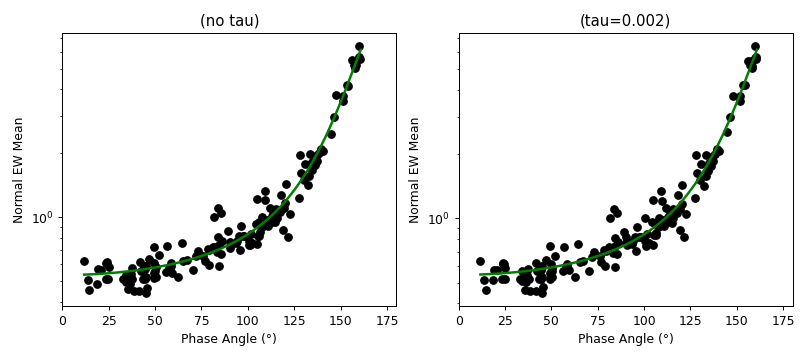

In [9]:
optimize_phase_tau(obsdata)

0.000: 0.1122425
0.001: 0.1119088
0.002: 0.1119590
0.003: 0.1123376
0.004: 0.1129912
0.005: 0.1138707
0.006: 0.1149318
0.007: 0.1161365
0.008: 0.1174519
0.009: 0.1188511

NO TAU:
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372

BEST TAU: 0.001: 0.11191
g1 = -0.657 / scale1 =  1.646 / weight1 = 0.626
g2 = -0.036 / scale2 =  0.982 / weight2 = 0.374
Base std: 0.1122425
Best std: 0.1119088


<IPython.core.display.Javascript object>


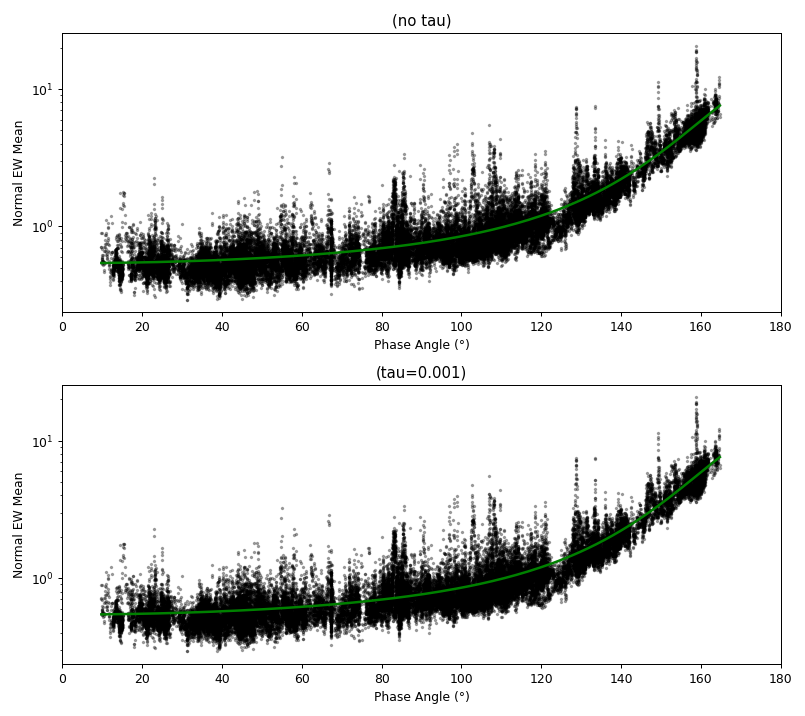

In [10]:
optimize_phase_tau(obsdata01, small_plot=True)

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>Based on the fact that adding tau does not reduce the scatter amongst the full dataset (either mean or 1-degree slices), we opt to remove consideratios of tau from the remainder of our research. Based on the analysis of the low-phase observations, this could result in an up to 10% error in EW.</b>
</div>